# Régression logistique

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, ParameterGrid,
                                     RandomizedSearchCV)
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from tools import (COLUMNS_QUANT, COLUMNS_CAT,
                   Modelisation, datasets, SearchCV, restauration_CV, 
                   graph_2scores_CV, graph_3scores_CV, graph_param_CV, 
                   best_score_CV, graph_2scores_CV_comp)
import json

## Matplotlib : 
# Pour affichage interactif (notamment 3D) dans notebook
# %matplotlib widget

# Pour affichage interactif (notamment 3D) dans une fenêtre qt externe au notebook
# %matplotlib qt

# Pour affichage simple dans notebook
# %config InlineBackend.figure_format = 'png'

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


Afin de comparer nos modèles en termes de performances brutes et de temps d'exécution, il est fondamental de déterminer quelques métriques de référence. Ici, il faut surtout faire en sorte d'éviter de prédire des non-clics qui seraient en réalité des clics (ie prédire trop de 0), quitte à prédire trop de 1. Autrement dit, il faut maximiser le recall et le NPV (Negative predictive value) afin de limiter les erreurs de type II. Le F1 Score, combinaison du recall et de la précision, est également pertinent. 

## 1. Modèle brut
### 1.1. Variables quantitatives

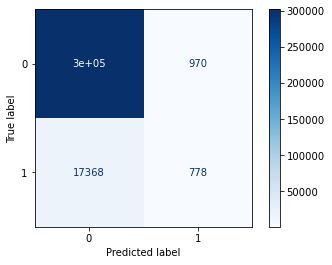

f1 : 0.0782
f3 : 0.0471
f5 : 0.0444
recall : 0.0429
negative predictive value : 0.9455
precision : 0.4451
roc_auc : 0.7400
training time : 1.958s
prediction time : 0.01s


In [4]:
m = Modelisation(X_quant, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

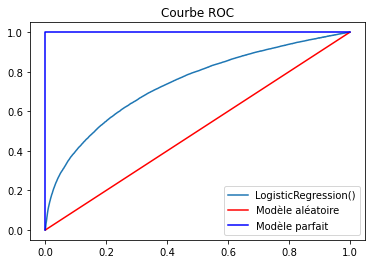

In [5]:
m.show_ROC()

In [6]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X_quant.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,-0.023943
campaignctrlast24h,0.358918
dayssincelastvisitdouble,-0.028270
ltf_nbglobaldisplay_4w,0.004646
ltf_nbpartnerdisplayssincelastclick,-0.020652
ltf_nbpartnerdisplay_90d,-0.010561
ltf_nbpartnerclick_90d,0.033429
ltf_nbpartnersales_90d,-0.005801
nbdayssincelastclick,-0.107124
nbdisplay_1hour,-0.224547


**Problème :** pas de scaling dans la cellule suivante

In [7]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_quant_scaled = datasets_df['X_quant_scaled']
X_ = add_constant(X_quant_scaled)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.197291
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1603554
Model:                          Logit   Df Residuals:                  1603540
Method:                           MLE   Df Model:                           13
Date:                Wed, 24 Mar 2021   Pseudo R-squ.:                 0.09816
Time:                        06:38:04   Log-Likelihood:            -3.1637e+05
converged:                       True   LL-Null:                   -3.5080e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.0392      0.0

Avec LASSO (+ univariate mais variable déjà exclue par Lasso): 

In [8]:
X1 = df[['contextid',
         'zonecostineuro',
         'campaignctrlast24h',
         'ltf_nbpartnerclick_90d',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'nbdisplayglobalapprox_1d_sum_xdevice']]
y1 = df['is_display_clicked']

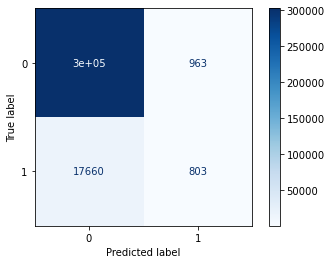

f1 : 0.0794
f3 : 0.0478
f5 : 0.0451
recall : 0.0435
negative predictive value : 0.9449
precision : 0.4547
roc_auc : 0.7382
training time : 1.606s
prediction time : 0.012s


In [9]:
m1 = Modelisation(X1, y1, LogisticRegression(), scaling=True)
m1.show_conf_matrix()
m1.show_metrics_score()

### 1.2. Variables catégorielles

In [10]:
# Nombre de valeurs distinctes
from tools import COLUMNS_CAT
for column in COLUMNS_CAT:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7
hour : 24
weekday : 7


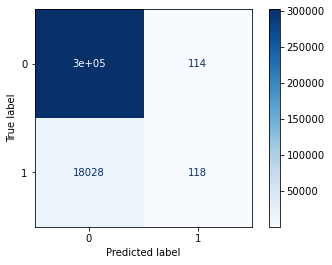

f1 : 0.0128
f3 : 0.0072
f5 : 0.0068
recall : 0.0065
negative predictive value : 0.9437
precision : 0.5086
roc_auc : 0.6892
training time : 7.085s
prediction time : 0.038s


In [11]:
m = Modelisation(X_cat, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

### 1.3. Variables quantitatives + catégorielles

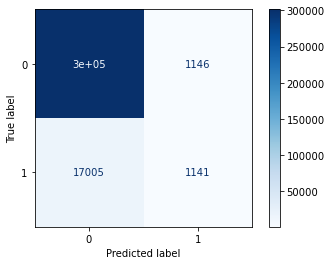

f1 : 0.1117
f3 : 0.0689
f5 : 0.0651
recall : 0.0629
negative predictive value : 0.9466
precision : 0.4989
roc_auc : 0.7585
training time : 8.278s
prediction time : 0.069s


In [12]:
m = Modelisation(X, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

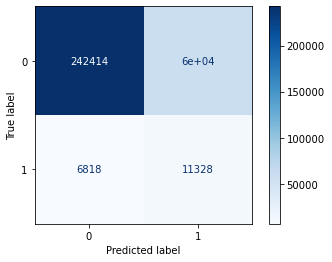

f1 : 0.2528
f3 : 0.4825
f5 : 0.5609
recall : 0.6243
negative predictive value : 0.9726
precision : 0.1585
roc_auc : 0.7794
training time : 7.006s
prediction time : 0.044s


In [13]:
m = Modelisation(X, y, LogisticRegression(class_weight='balanced'), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

## 2. Tuning des hyperparamètres avec GridSearchCV

In [14]:
model = LogisticRegression()

cv_params = {
        "C": np.logspace(-6, 2, 30),
        "class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                         {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                         {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                         {0:1, 1:30}, {0:1, 1:32}]
        }

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

540


In [15]:
# SearchCV(model, cv_params, data_frac=1, scaling=True, scoring=scoring, n_jobs=28)

In [16]:
dico, results = restauration_CV('LR_CV_Grid_540_1')

model : LogisticRegression()
model_name : LR
type : GridSearchCV
len_grid : 540
data_frac : 1
temps : 1h, 28min, 25.432s
n_jobs : 28
params : {'C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02]), 'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 6}, {0: 1, 1: 8}, {0: 1, 1: 10}, {0: 1, 1: 12}, {0: 1, 1: 14}, {0: 1, 1: 16}, {0: 1, 1: 18}, {0: 1, 1: 20}, {0: 1, 1: 22}, {0: 1, 1: 24}, {0: 1, 1: 26}, {0: 1, 1: 28}, {0: 1, 1: 30}, {0: 1, 1: 32}]}
scoring : {'recall': 'recall', 'precision'

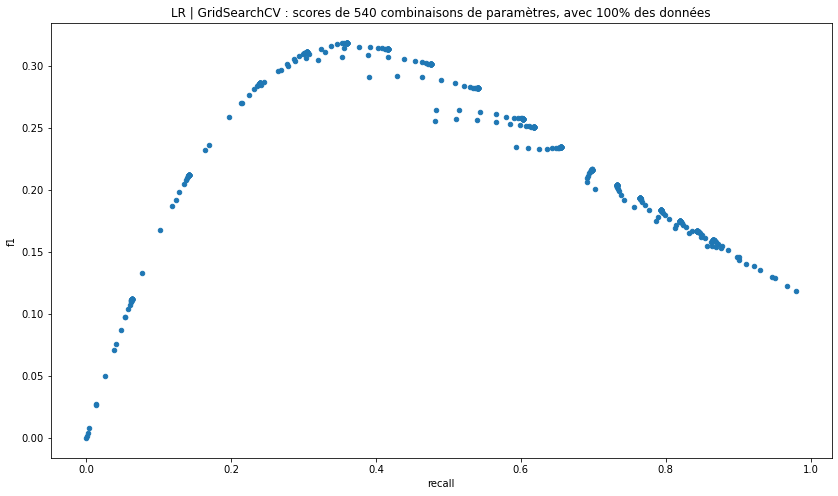

In [17]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20)

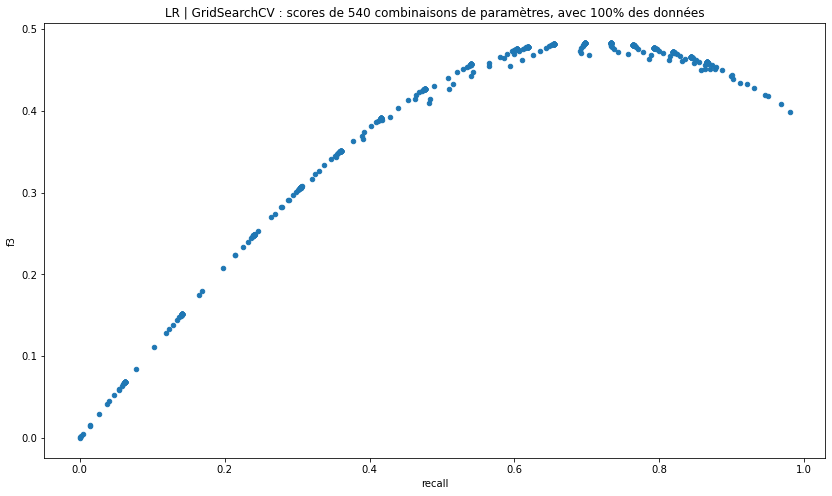

In [18]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=20)

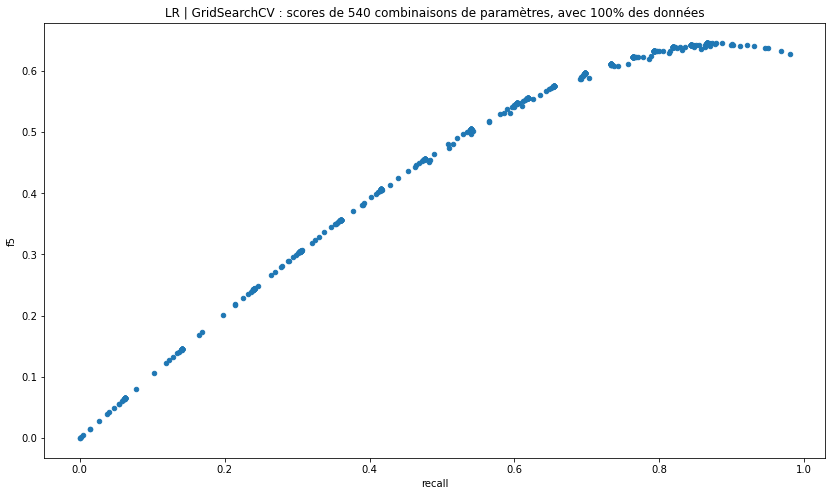

In [19]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=20)

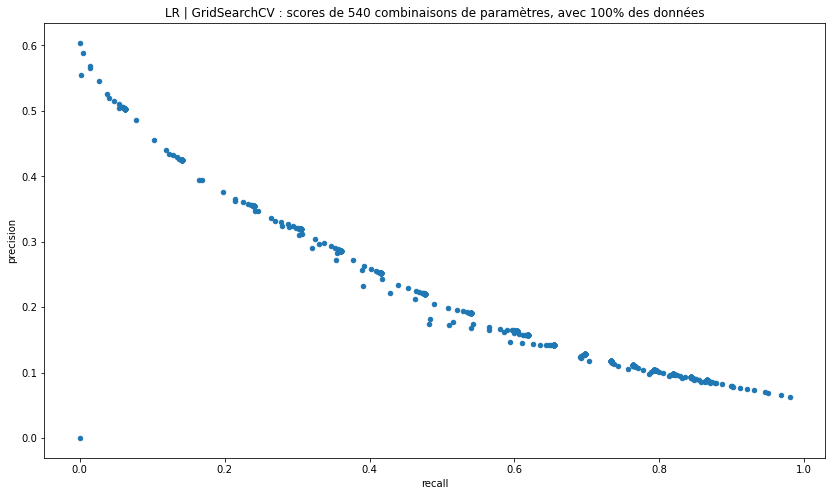

In [20]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=20)

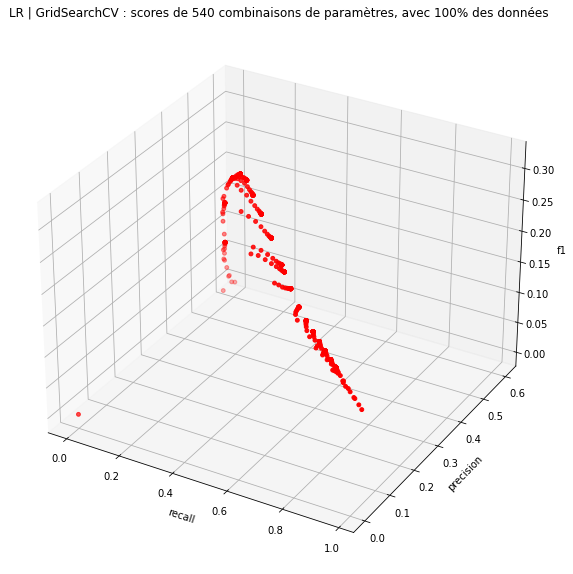

In [21]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=15)

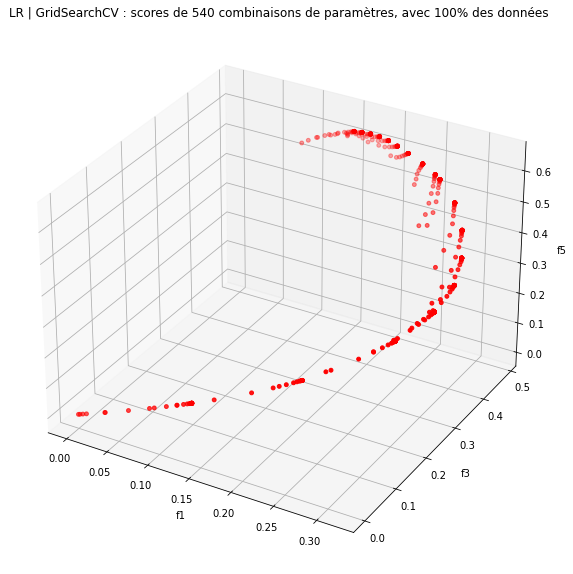

In [22]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=15)

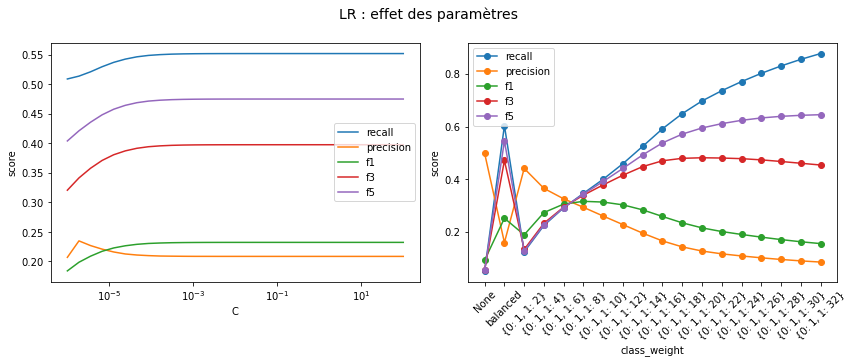

In [23]:
graph_param_CV(dico, results, xscale={'C': 'log'}, ncols=2, height=5, width=6)

In [24]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,mean_test_recall,std_test_recall,rank_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
245,52.727007,7.791396,1.829863,0.396834,0.003857,"{0: 1, 1: 20}","{'C': 0.0038566204211634724, 'class_weight': {...",0.697763,0.002736,182,...,332,0.216654,0.001282,271,0.48317,0.002063,1,0.59596,0.00235,181
263,50.282377,8.246513,1.664756,0.31946,0.007279,"{0: 1, 1: 20}","{'C': 0.007278953843983146, 'class_weight': {0...",0.697752,0.002725,183,...,330,0.216657,0.001285,269,0.483169,0.002062,2,0.595955,0.002344,182
281,54.504,11.444038,1.661199,0.361354,0.013738,"{0: 1, 1: 20}","{'C': 0.013738237958832637, 'class_weight': {0...",0.697742,0.002682,186,...,331,0.216654,0.001272,270,0.483162,0.002029,3,0.595945,0.002303,183
335,51.839626,9.666495,1.805333,0.448584,0.092367,"{0: 1, 1: 20}","{'C': 0.09236708571873865, 'class_weight': {0:...",0.697731,0.002718,187,...,335,0.216652,0.001271,272,0.483155,0.002037,4,0.595936,0.002324,185
353,52.618434,10.270903,2.091436,0.4261,0.174333,"{0: 1, 1: 20}","{'C': 0.17433288221999874, 'class_weight': {0:...",0.697731,0.002718,187,...,333,0.216652,0.001271,273,0.483155,0.002036,5,0.595936,0.002323,186
371,52.760804,9.441183,2.352712,0.339121,0.329034,"{0: 1, 1: 20}","{'C': 0.3290344562312671, 'class_weight': {0: ...",0.697731,0.002718,187,...,333,0.216652,0.001271,273,0.483155,0.002036,5,0.595936,0.002323,186
479,53.356385,10.408031,2.072429,0.261547,14.873521,"{0: 1, 1: 20}","{'C': 14.873521072935118, 'class_weight': {0: ...",0.69772,0.002702,192,...,336,0.216649,0.001266,275,0.483149,0.002023,7,0.595928,0.002308,189
533,53.35327,10.401444,2.046144,0.656528,100.0,"{0: 1, 1: 20}","{'C': 100.0, 'class_weight': {0: 1, 1: 20}}",0.69772,0.002702,192,...,336,0.216649,0.001266,275,0.483149,0.002023,7,0.595928,0.002308,189
497,51.977797,8.991615,1.762581,0.437772,28.072162,"{0: 1, 1: 20}","{'C': 28.072162039411758, 'class_weight': {0: ...",0.69772,0.002702,192,...,336,0.216649,0.001266,275,0.483149,0.002023,7,0.595928,0.002308,189
515,51.604638,9.362941,2.038468,0.35868,52.983169,"{0: 1, 1: 20}","{'C': 52.98316906283702, 'class_weight': {0: 1...",0.69772,0.002702,192,...,336,0.216649,0.001266,275,0.483149,0.002023,7,0.595928,0.002308,189


Meilleure combinaison de paramètres pour f3 :


{'C': 0.0038566204211634724, 'class_weight': {0: 1, 1: 20}}

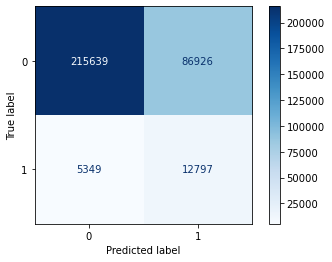

f1 : 0.2171
f3 : 0.4865
f5 : 0.6013
recall : 0.7052
negative predictive value : 0.9758
precision : 0.1283
roc_auc : 0.7804
training time : 6.415s
prediction time : 0.057s


In [25]:
m = Modelisation(X, y, LogisticRegression(**best_params), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [26]:
PARAMS = {}
PARAMS[dico['model_name']] = best_params

## 3. Régression logistique avec oversampling

In [27]:
len(y[y == 1]) / (len(y[y == 0]))

0.06049828183239467

In [28]:
df_small = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.05)
df_small.shape

(80525, 48)

In [29]:
datasets_df_small = datasets(df_small, verbose=False)
X_small = datasets_df_small['X']
y_small = datasets_df_small['y']

In [30]:
categorical_features = list(range(len(COLUMNS_QUANT), len(X.columns)))
print(categorical_features)

over = SMOTENC(categorical_features=categorical_features, 
              sampling_strategy=1, 
              k_neighbors=5,
              random_state=1234,
              n_jobs=-1)

pipeline = Pipeline_imb([
            ('over', over),
            ('model', LogisticRegression())
            ])

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


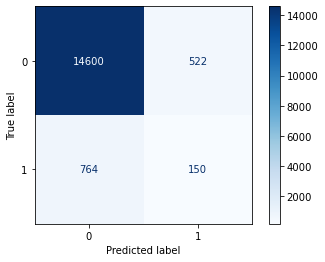

f1 : 0.1892
f3 : 0.1686
f5 : 0.1658
recall : 0.1641
negative predictive value : 0.9503
precision : 0.2232
roc_auc : 0.6924
training time : 49.282s
prediction time : 0.011s


In [31]:
m = Modelisation(X_small, y_small, pipeline, scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [32]:
over = RandomOverSampler(sampling_strategy=1, random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('model', LogisticRegression())
            ])

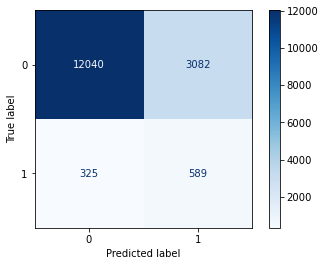

f1 : 0.2569
f3 : 0.4951
f5 : 0.5774
recall : 0.6444
negative predictive value : 0.9737
precision : 0.1604
roc_auc : 0.7872
training time : 0.852s
prediction time : 0.008s


In [33]:
m = Modelisation(X_small, y_small, pipeline, scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

### 3.1. GridSearchCV avec RandomOverSampler

In [34]:
over = RandomOverSampler(random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('model', LogisticRegression())
            ])

cv_params = {
        "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
        "model__C": np.logspace(-6, 2, 30),
        "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                                 {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                                 {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                                 {0:1, 1:30}, {0:1, 1:32}]
        }

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

3240


In [35]:
# SearchCV(pipeline, cv_params, data_frac=1, scaling=True, scoring=scoring, n_jobs=28)

In [36]:
dico, results = restauration_CV('RandomOver_LR_CV_Grid_3240_1')

model : Pipeline(steps=[('over', RandomOverSampler(random_state=1234)),
                ('model', LogisticRegression())])
model_name : RandomOver_LR
type : GridSearchCV
len_grid : 3240
data_frac : 1
temps : 8h, 35min, 29.782s
n_jobs : 28
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02]), 'model__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 6}, {0: 1, 1: 8}, {0: 1, 1: 10}, {0: 1, 1: 12}, {0: 1, 1: 14}, {0

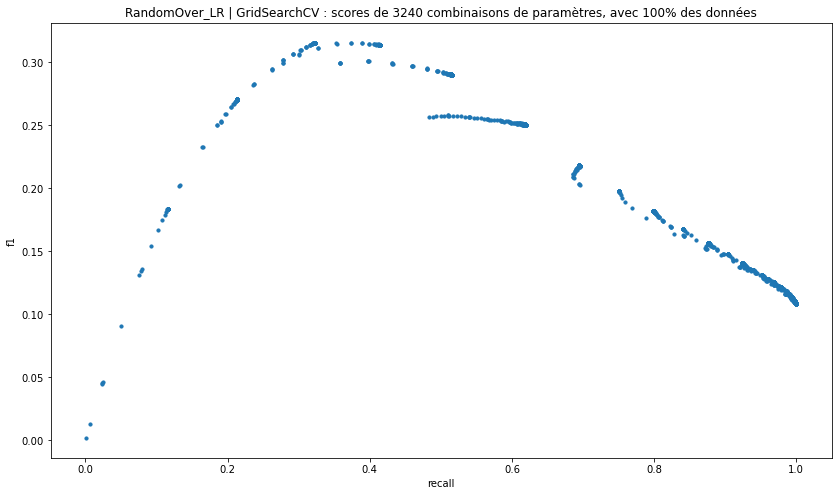

In [37]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=10)

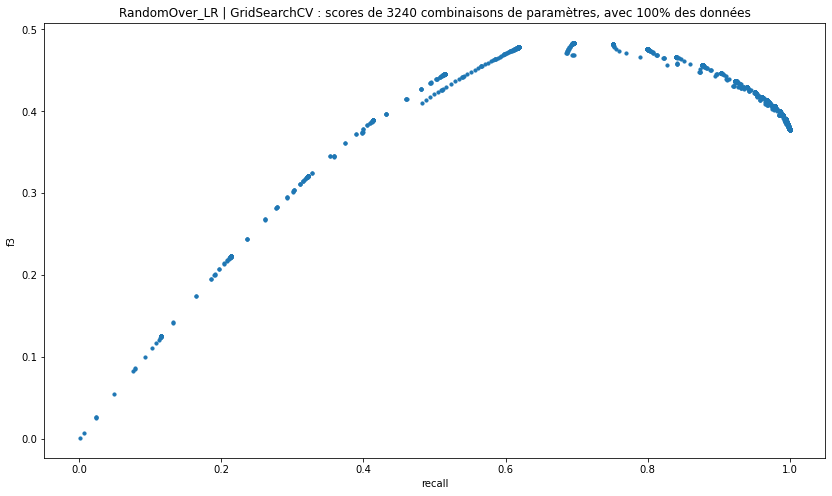

In [38]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=10)

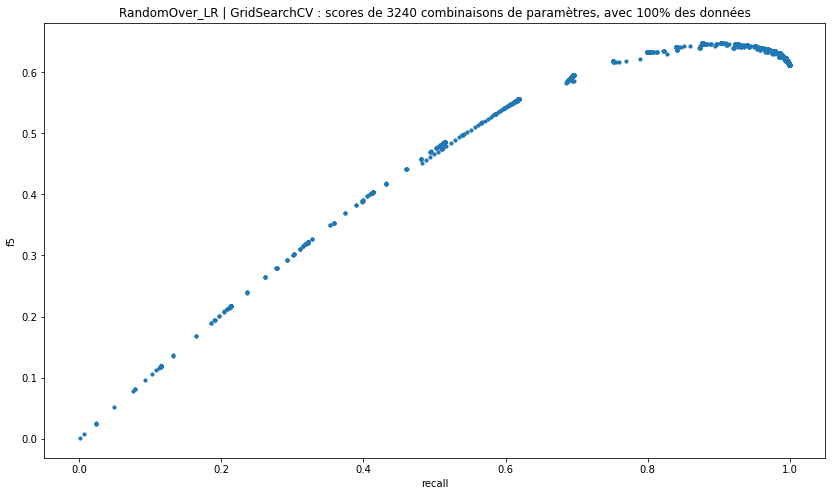

In [39]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=10)

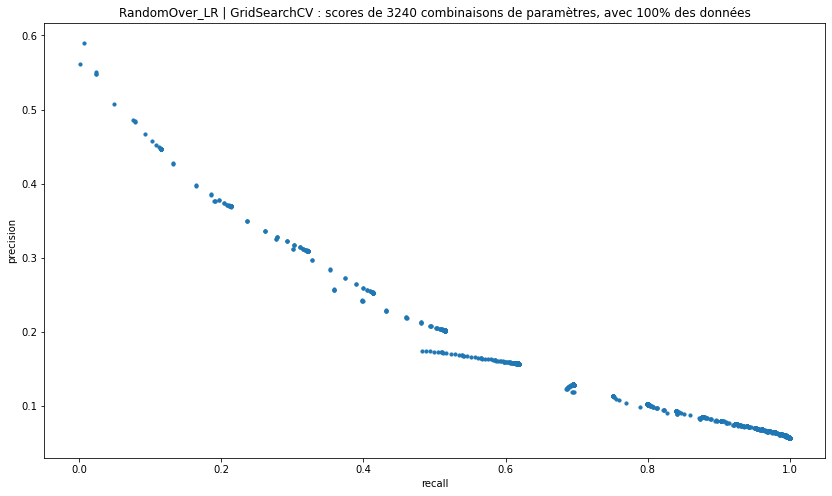

In [40]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=10)

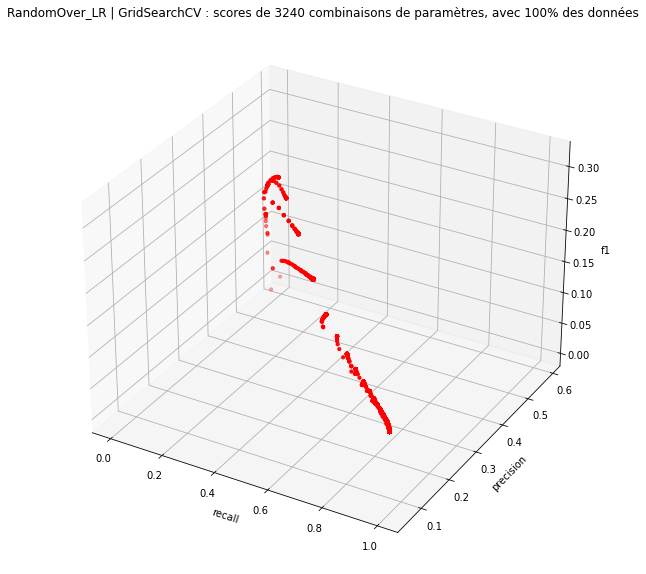

In [41]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=10)

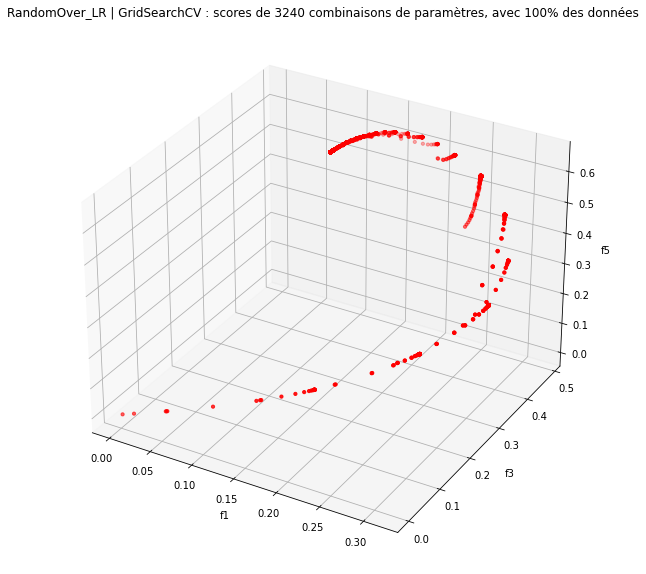

In [42]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=10)

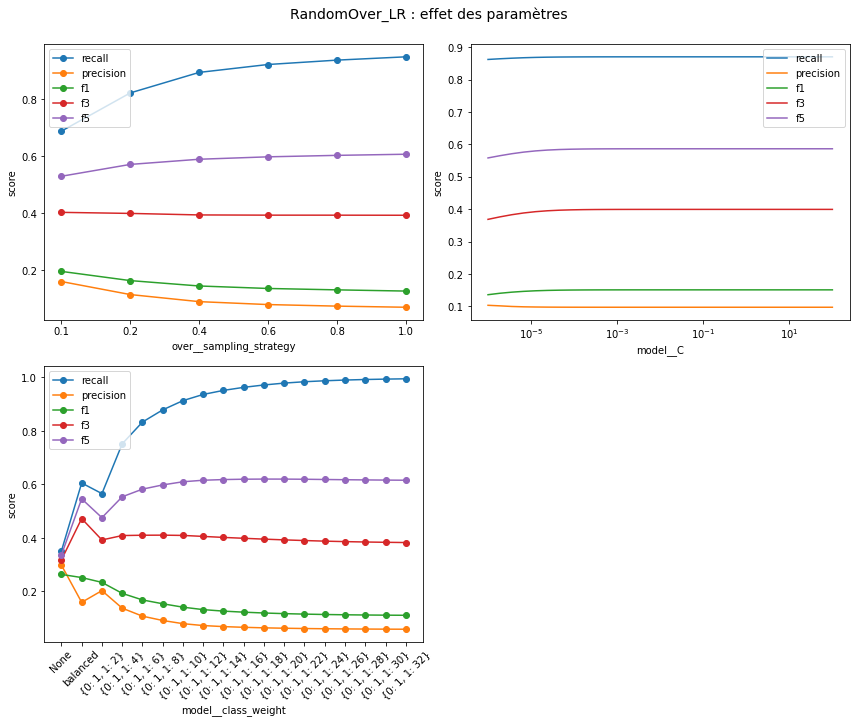

In [43]:
graph_param_CV(dico, results, xscale={'model__C': 'log'}, ncols=2, height=5, width=6)

In [44]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_over__sampling_strategy,params,mean_test_recall,std_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
2067,56.81133,3.452921,1.542658,0.212259,0.174333,"{0: 1, 1: 2}",0.6,"{'model__C': 0.17433288221999874, 'model__clas...",0.694976,0.002587,...,601,0.218312,0.001103,565,0.483736,0.002005,1,0.595036,0.002309,2571
2175,59.564902,2.036516,1.379007,0.18574,0.329034,"{0: 1, 1: 2}",0.6,"{'model__C': 0.3290344562312671, 'model__class...",0.694976,0.002587,...,602,0.218312,0.001103,566,0.483736,0.002005,2,0.595036,0.002309,2572
2283,55.744323,4.236956,1.424434,0.19977,0.621017,"{0: 1, 1: 2}",0.6,"{'model__C': 0.6210169418915616, 'model__class...",0.694976,0.002587,...,604,0.218311,0.001103,568,0.483735,0.002005,3,0.595036,0.002309,2573
1959,54.695872,7.369467,1.456913,0.241345,0.092367,"{0: 1, 1: 2}",0.6,"{'model__C': 0.09236708571873865, 'model__clas...",0.694976,0.002587,...,603,0.218311,0.001103,567,0.483735,0.002005,4,0.595036,0.002309,2574
2607,58.67842,4.502595,1.734636,0.160016,4.175319,"{0: 1, 1: 2}",0.6,"{'model__C': 4.175318936560401, 'model__class_...",0.694976,0.002587,...,605,0.218311,0.001102,569,0.483735,0.002004,5,0.595035,0.002309,2575
2931,57.421512,1.879653,1.488071,0.197749,28.072162,"{0: 1, 1: 2}",0.6,"{'model__C': 28.072162039411758, 'model__class...",0.694976,0.002587,...,605,0.218311,0.001102,569,0.483735,0.002004,5,0.595035,0.002309,2575
3039,58.403658,0.588741,1.725191,0.052539,52.983169,"{0: 1, 1: 2}",0.6,"{'model__C': 52.98316906283702, 'model__class_...",0.694976,0.002587,...,605,0.218311,0.001102,569,0.483735,0.002004,5,0.595035,0.002309,2575
3147,57.536709,5.513063,1.427529,0.208026,100.0,"{0: 1, 1: 2}",0.6,"{'model__C': 100.0, 'model__class_weight': {0:...",0.694976,0.002587,...,605,0.218311,0.001102,569,0.483735,0.002004,5,0.595035,0.002309,2575
2823,58.798373,3.265727,1.559639,0.16711,14.873521,"{0: 1, 1: 2}",0.6,"{'model__C': 14.873521072935118, 'model__class...",0.694976,0.002587,...,605,0.218311,0.001102,569,0.483735,0.002004,5,0.595035,0.002309,2575
2391,60.589348,3.363221,1.527824,0.115408,1.172102,"{0: 1, 1: 2}",0.6,"{'model__C': 1.1721022975334794, 'model__class...",0.694976,0.002587,...,605,0.218311,0.001102,569,0.483735,0.002004,5,0.595035,0.002309,2575


Meilleure combinaison de paramètres pour f3 :


{'model__C': 0.17433288221999874,
 'model__class_weight': {0: 1, 1: 2},
 'over__sampling_strategy': 0.6}

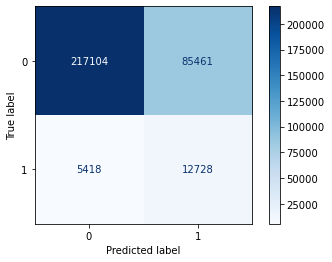

f1 : 0.2188
f3 : 0.4867
f5 : 0.5997
recall : 0.7014
negative predictive value : 0.9757
precision : 0.1296
roc_auc : 0.7804
training time : 14.814s
prediction time : 0.032s


In [45]:
m = Modelisation(X, y, pipeline.set_params(**best_params), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [46]:
PARAMS[dico['model_name']] = best_params

### 3.2. GridSearchCV avec SMOTE

In [47]:
categorical_features = list(range(len(COLUMNS_QUANT), len(X.columns)))
print(categorical_features)

over = SMOTENC(categorical_features=categorical_features,
              random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('model', LogisticRegression())
            ])

cv_params = {
        "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
        "over__k_neighbors": [3, 4, 5],
        "model__C": np.logspace(-6, 2, 30),
        "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                                 {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                                 {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                                 {0:1, 1:30}, {0:1, 1:32}] 
        }

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
9720


In [48]:
# SearchCV(pipeline, cv_params, data_frac=0.1, random=True, n_iter=2500, scaling=True, scoring=scoring, random_state=1234, n_jobs=28)

In [49]:
dico, results = restauration_CV('SMOTENC_LR_CV_Randomized2500_9720_0.1')

model : Pipeline(steps=[('over',
                 SMOTENC(categorical_features=[13, 14, 15, 16, 17, 18, 19, 20,
                                               21, 22, 23, 24, 25, 26, 27, 28,
                                               29, 30, 31, 32, 33, 34, 35, 36,
                                               37, 38, 39, 40, 41, 42, ...],
                         random_state=1234)),
                ('model', LogisticRegression())])
model_name : SMOTENC_LR
type : RandomizedSearchCV
len_grid : 9720
n_iter : 2500
data_frac : 0.1
temps : 17h, 23min, 52.771s
n_jobs : 28
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'over__k_neighbors': [3, 4, 5], 'model__C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.8

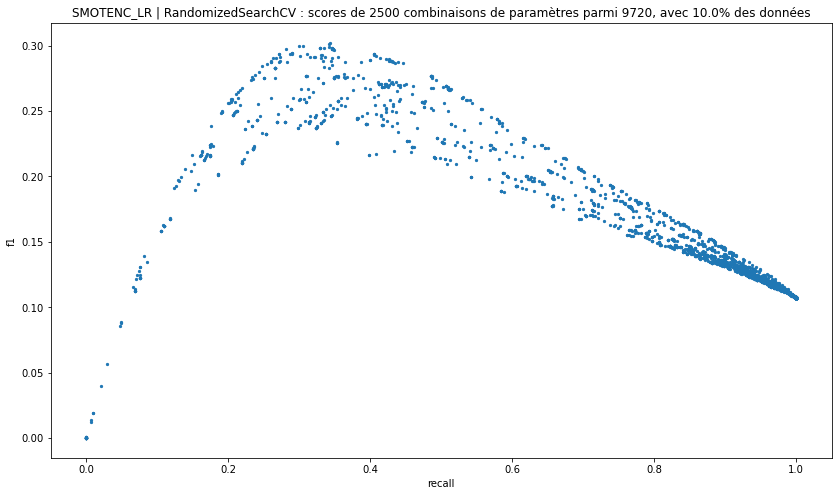

In [50]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=5)

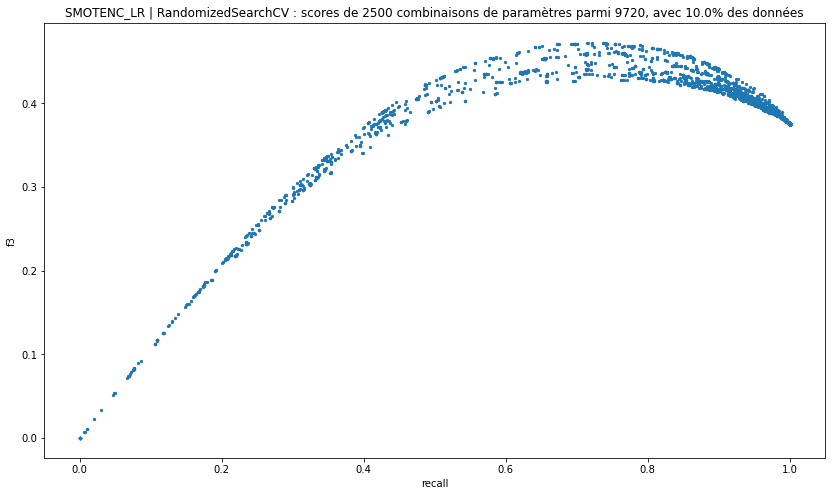

In [51]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=5)

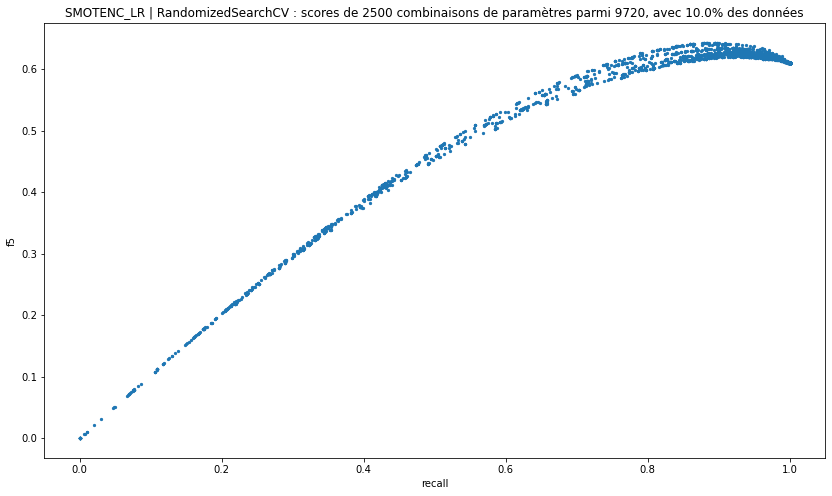

In [52]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=5)

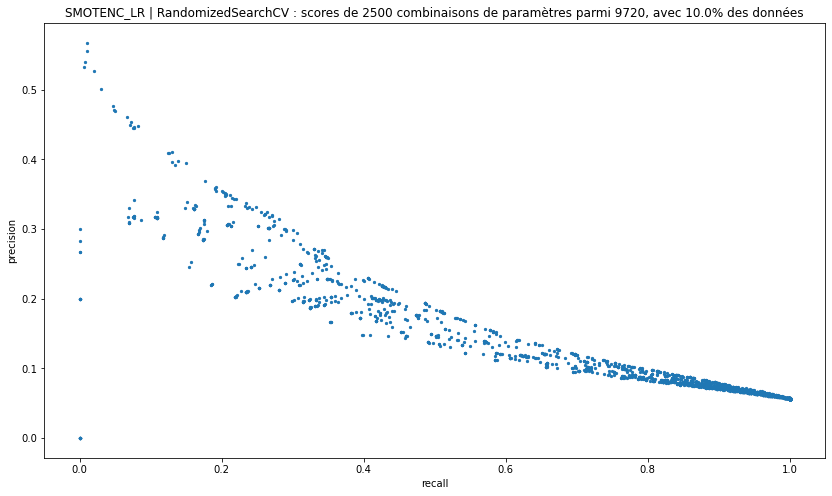

In [53]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=5)

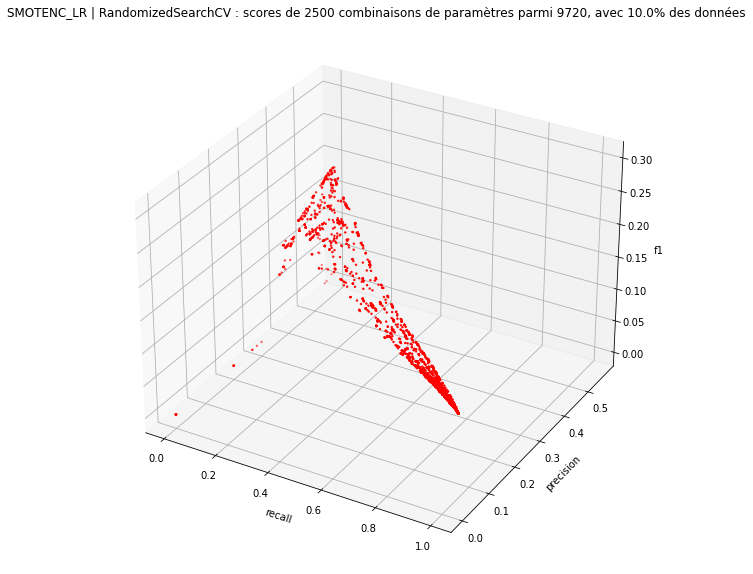

In [54]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=2)

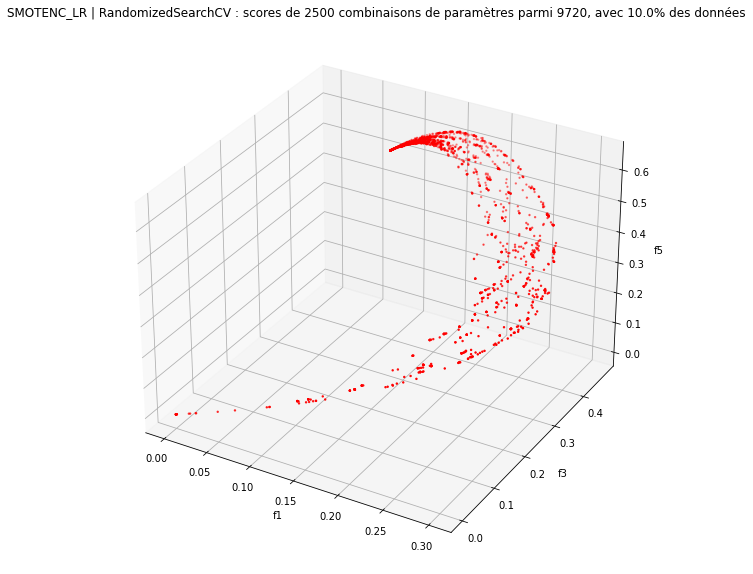

In [55]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=2)

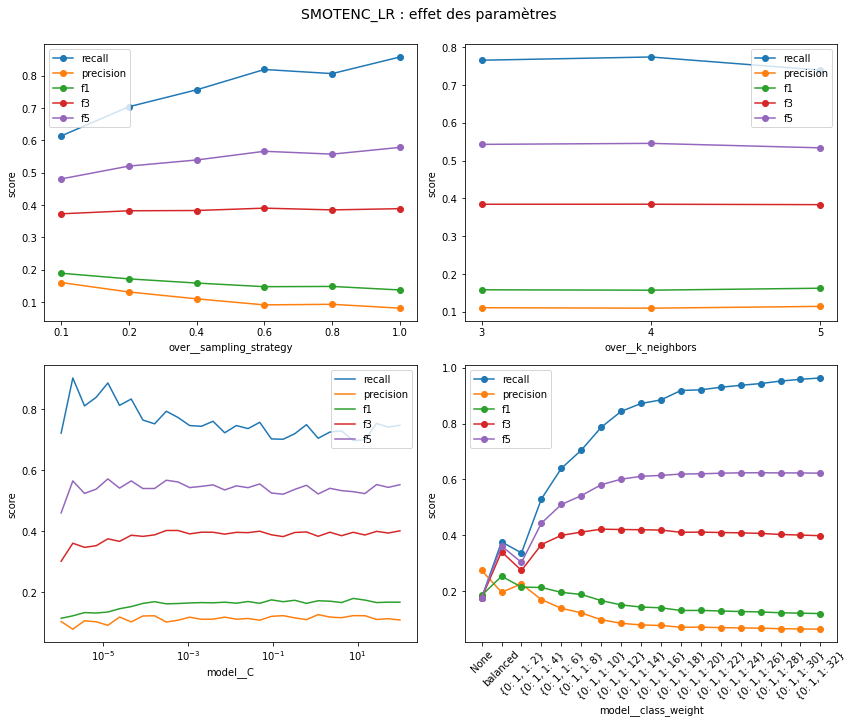

In [56]:
graph_param_CV(dico, results, xscale={'model__C': 'log'}, ncols=2, height=5, width=6)

In [57]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_over__sampling_strategy,param_over__k_neighbors,param_model__class_weight,param_model__C,params,mean_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
1894,122.85525,1.705308,0.095912,0.004276,0.1,4,"{0: 1, 1: 18}",0.007279,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.740558,...,707,0.193058,0.003086,632,0.472501,0.004765,1,0.607901,0.005793,1598
699,70.136363,5.192241,0.072544,0.013143,0.1,5,"{0: 1, 1: 18}",28.072162,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.71534,...,676,0.200246,0.002566,593,0.472306,0.005349,2,0.597147,0.007695,1684
1736,118.47275,6.866779,0.090297,0.017192,0.1,4,"{0: 1, 1: 18}",0.025929,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.738025,...,705,0.193543,0.003055,630,0.472251,0.004617,3,0.60669,0.005685,1614
706,69.925098,3.153283,0.072465,0.014113,0.1,4,"{0: 1, 1: 18}",14.873521,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.737034,...,702,0.193816,0.003146,628,0.47225,0.004793,4,0.606277,0.005834,1622
1846,123.508714,2.819567,0.084658,0.013809,0.1,4,"{0: 1, 1: 18}",100.0,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.737034,...,702,0.193816,0.003146,628,0.47225,0.004793,4,0.606277,0.005834,1622
490,77.285966,9.151936,0.075884,0.015168,0.1,3,"{0: 1, 1: 16}",0.001083,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.71457,...,678,0.200057,0.002339,595,0.471842,0.005873,6,0.596535,0.008314,1689
1371,125.086937,2.795855,0.123019,0.026733,0.1,5,"{0: 1, 1: 18}",0.003857,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.720846,...,683,0.197971,0.00278,612,0.471654,0.005522,7,0.599095,0.007608,1678
1790,121.823283,5.244986,0.105157,0.035144,0.1,4,"{0: 1, 1: 16}",0.003857,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.697502,...,638,0.205402,0.002957,551,0.471513,0.005814,8,0.588926,0.00819,1716
1813,123.830424,2.056089,0.111924,0.03351,0.1,5,"{0: 1, 1: 20}",0.092367,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.754213,...,727,0.188611,0.002242,666,0.47142,0.004274,9,0.61281,0.006437,1180
936,72.824647,5.022277,0.084062,0.01354,0.1,5,"{0: 1, 1: 20}",52.983169,"{'over__sampling_strategy': 0.1, 'over__k_neig...",0.753882,...,723,0.188668,0.002212,662,0.471387,0.004301,10,0.612655,0.006537,1182


Meilleure combinaison de paramètres pour f3 :


{'over__sampling_strategy': 0.1,
 'over__k_neighbors': 4,
 'model__class_weight': {0: 1, 1: 18},
 'model__C': 0.007278953843983146}

In [58]:
best_params['over__n_jobs'] = -1

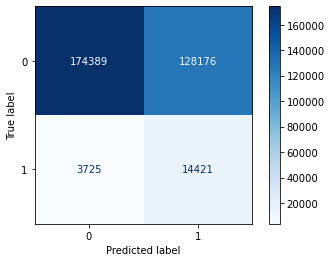

f1 : 0.1794
f3 : 0.4714
f5 : 0.6288
recall : 0.7947
negative predictive value : 0.9791
precision : 0.1011
roc_auc : 0.7732
training time : 23min, 5.474s
prediction time : 0.045s


In [59]:
m = Modelisation(X, y, pipeline.set_params(**best_params), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [60]:
PARAMS[dico['model_name']] = best_params

### 3.3. Comparaison

In [61]:
dr1 = restauration_CV('LR_CV_Grid_540_1', verbose=False)
dr2 = restauration_CV('RandomOver_LR_CV_Grid_3240_1', verbose=False)
dr3 = restauration_CV('SMOTENC_LR_CV_Randomized2500_9720_0.1', verbose=False)

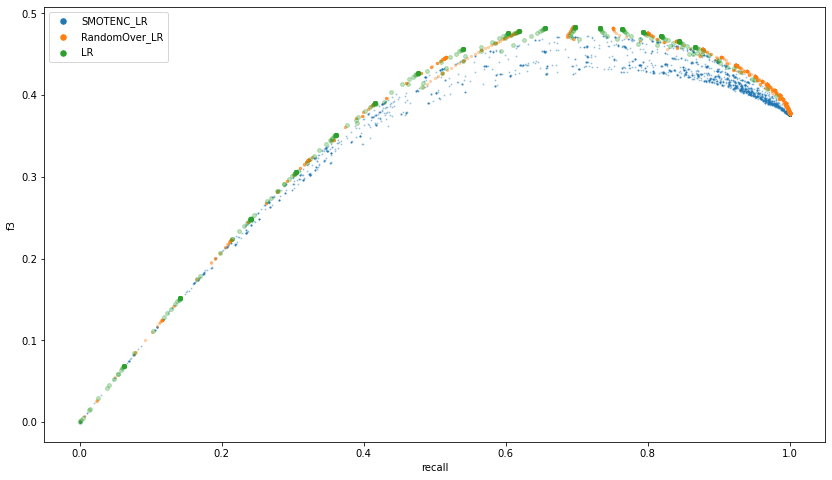

In [62]:
graph_2scores_CV_comp([dr3, dr2, dr1], 'recall', 'f3', s=[1, 5, 15], alpha=0.3)

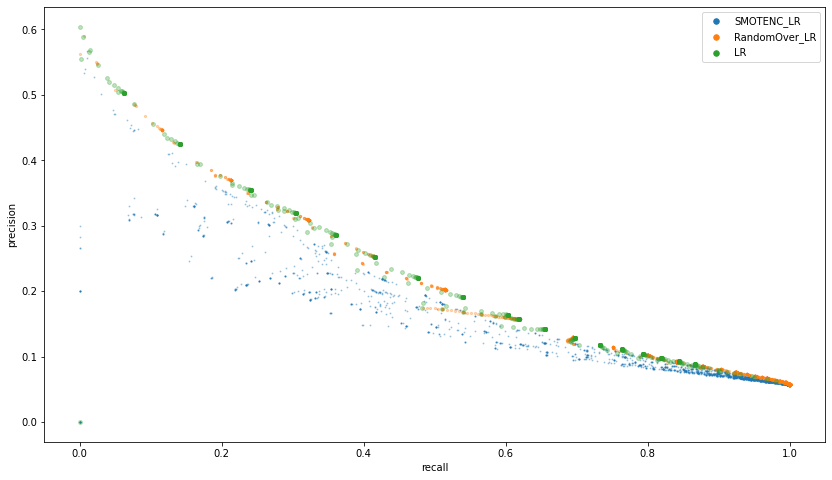

In [63]:
graph_2scores_CV_comp([dr3, dr2, dr1], 'recall', 'precision', s=[1, 5, 15], alpha=0.3)

## 4. Régression logistique avec RFECV

In [64]:
with open("backups/RFECV_LR.json", 'r') as f:
    export = json.load(f)
    columns_quant_RFECV = export['columns_quant']
    columns_cat_RFECV = export['columns_cat']

In [65]:
datasets_df_RFECV = datasets(df, columns_quant=columns_quant_RFECV, columns_cat=columns_cat_RFECV)
X_RFECV = datasets_df_RFECV['X']

Columns_quant :


['zonecostineuro',
 'nbdisplay_1hour',
 'display_size',
 'campaignctrlast24h',
 'nbdayssincelastclick']


Columns_cat :


['display_env_app_ios',
 'is_interstitial_True',
 'device_type_Desktop',
 'campaignscenario_13',
 'target_env_2',
 'device_type_iPhone']


Nombre de variables pour X_quant : 5



Index(['zonecostineuro', 'nbdisplay_1hour', 'display_size',
       'campaignctrlast24h', 'nbdayssincelastclick'],
      dtype='object')


Nombre de variables pour X_cat : 6



Index(['display_env_app_ios', 'is_interstitial_True', 'device_type_Desktop',
       'campaignscenario_13', 'target_env_2', 'device_type_iPhone'],
      dtype='object')


Nombre de variables pour X : 11


In [66]:
model = LogisticRegression()

cv_params = {
        "C": np.logspace(-6, 2, 30),
        "class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                         {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                         {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                         {0:1, 1:30}, {0:1, 1:32}] 
        }

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

540


In [67]:
# SearchCV(model, cv_params, datasets_df=datasets_df_RFECV, data_frac=1, scaling=True, scoring=scoring, n_jobs=28, name='RFECV')

In [68]:
dico, results = restauration_CV('LR_RFECV_CV_Grid_540_1')

model : LogisticRegression()
model_name : LR_RFECV
type : GridSearchCV
len_grid : 540
data_frac : 1
temps : 10min, 5.646s
n_jobs : 28
params : {'C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02]), 'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 6}, {0: 1, 1: 8}, {0: 1, 1: 10}, {0: 1, 1: 12}, {0: 1, 1: 14}, {0: 1, 1: 16}, {0: 1, 1: 18}, {0: 1, 1: 20}, {0: 1, 1: 22}, {0: 1, 1: 24}, {0: 1, 1: 26}, {0: 1, 1: 28}, {0: 1, 1: 30}, {0: 1, 1: 32}]}
scoring : {'recall': 'recall', 'precision

In [69]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,mean_test_recall,std_test_recall,rank_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
263,5.187472,0.762991,1.080332,0.18208,0.007279,"{0: 1, 1: 20}","{'C': 0.007278953843983146, 'class_weight': {0...",0.682186,0.003042,182,...,330,0.221549,0.001422,269,0.481825,0.002408,1,0.588122,0.002726,181
281,5.8291,1.117693,1.248459,0.231291,0.013738,"{0: 1, 1: 20}","{'C': 0.013738237958832637, 'class_weight': {0...",0.682175,0.003045,183,...,331,0.221546,0.00142,270,0.481817,0.002408,2,0.588113,0.002727,182
245,4.929561,0.424179,1.082412,0.215514,0.003857,"{0: 1, 1: 20}","{'C': 0.0038566204211634724, 'class_weight': {...",0.682164,0.003049,184,...,346,0.221536,0.001408,285,0.481803,0.002396,3,0.5881,0.002722,183
353,5.693342,0.434268,1.244623,0.152506,0.174333,"{0: 1, 1: 20}","{'C': 0.17433288221999874, 'class_weight': {0:...",0.682153,0.00305,185,...,332,0.22154,0.001421,271,0.481803,0.002411,4,0.588095,0.002731,184
461,4.889386,0.629802,1.167223,0.163732,7.880463,"{0: 1, 1: 20}","{'C': 7.880462815669905, 'class_weight': {0: 1...",0.682153,0.00305,185,...,333,0.221539,0.001422,272,0.481802,0.002412,5,0.588094,0.002731,185
479,4.965118,0.461091,1.117018,0.157809,14.873521,"{0: 1, 1: 20}","{'C': 14.873521072935118, 'class_weight': {0: ...",0.682153,0.00305,185,...,333,0.221539,0.001422,272,0.481802,0.002412,5,0.588094,0.002731,185
533,4.991714,0.381619,1.064785,0.149242,100.0,"{0: 1, 1: 20}","{'C': 100.0, 'class_weight': {0: 1, 1: 20}}",0.682153,0.00305,185,...,333,0.221539,0.001422,272,0.481802,0.002412,5,0.588094,0.002731,185
497,5.770982,0.363907,1.089166,0.151528,28.072162,"{0: 1, 1: 20}","{'C': 28.072162039411758, 'class_weight': {0: ...",0.682153,0.00305,185,...,333,0.221539,0.001422,272,0.481802,0.002412,5,0.588094,0.002731,185
407,5.29691,0.520542,1.209233,0.085502,1.172102,"{0: 1, 1: 20}","{'C': 1.1721022975334794, 'class_weight': {0: ...",0.682153,0.00305,185,...,333,0.221539,0.001422,272,0.481802,0.002412,5,0.588094,0.002731,185
425,4.98723,0.35812,1.081735,0.150524,2.212216,"{0: 1, 1: 20}","{'C': 2.21221629107045, 'class_weight': {0: 1,...",0.682153,0.00305,185,...,333,0.221539,0.001422,272,0.481802,0.002412,5,0.588094,0.002731,185


Meilleure combinaison de paramètres pour f3 :


{'C': 0.007278953843983146, 'class_weight': {0: 1, 1: 20}}

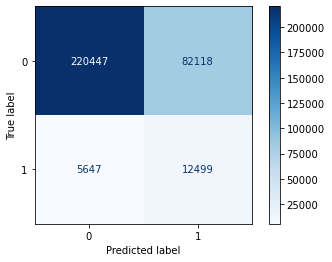

f1 : 0.2217
f3 : 0.4846
f5 : 0.5927
recall : 0.6888
negative predictive value : 0.9750
precision : 0.1321
roc_auc : 0.7763
training time : 1.843s
prediction time : 0.01s


In [70]:
m = Modelisation(X_RFECV, y, LogisticRegression(**best_params), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [71]:
PARAMS[dico['model_name']] = best_params

In [72]:
with open(f"backups/PARAMS_LR.json", 'w') as f:
    json.dump(PARAMS, f, indent=2)

### 4.1. Comparaison

In [73]:
dr1 = restauration_CV('LR_CV_Grid_540_1', verbose=False)
dr2 = restauration_CV('LR_RFECV_CV_Grid_540_1', verbose=False)

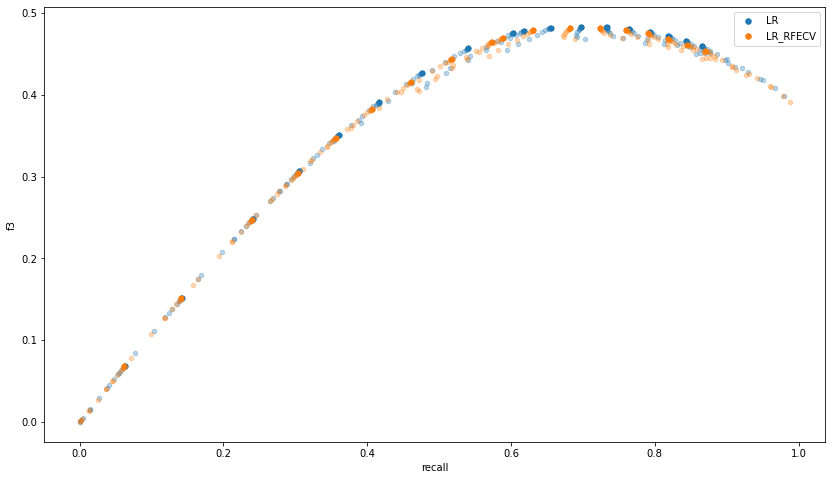

In [74]:
graph_2scores_CV_comp([dr1, dr2], 'recall', 'f3', alpha=0.3)

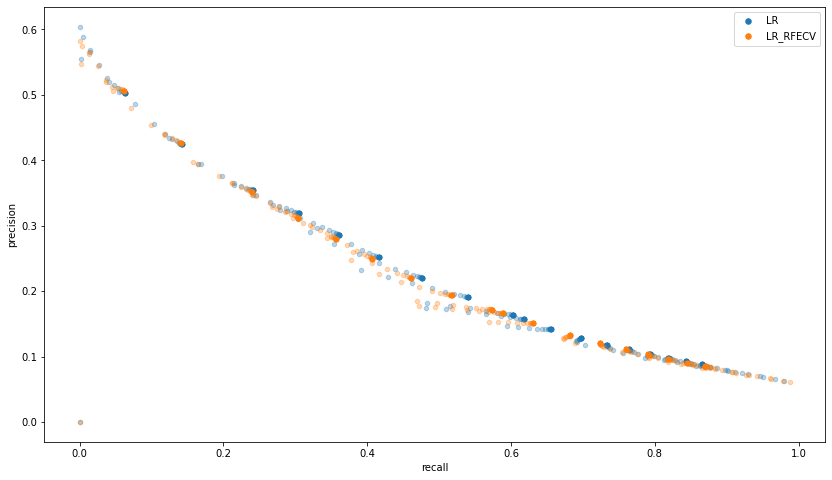

In [75]:
graph_2scores_CV_comp([dr1, dr2], 'recall', 'precision', alpha=0.3)

In [76]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:26:15
